In [7]:
# Import Block
import scanpy as sc
import numpy as np
import pandas as pd
# import imageio.v3 as iio

from skimage.io import imread_collection, imsave
from skmisc.loess import loess
from sklearn import decomposition

from umap import UMAP
import leidenalg
import igraph as ig

from matplotlib import pyplot as plt
from pathlib import Path
import os.path

In [2]:
# Read in Scanpy Adata file (h5ad)
adata = sc.read_h5ad(os.path.normpath("../data/adata_course_filt.h5ad")) # Win

In [27]:
display(adata)

AnnData object with n_obs × n_vars = 14640 × 22429
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'fraction_mito', 'n_genes', 'num_spliced', 'num_ambiguous', 'num_unspliced', 'fraction_spliced', 'is_cell', 'is_high_quality', 'is_nonambient', 'is_not_debris', 'soupc_rho', 'n_counts', 'sample', 'age', 'genotype', 'dark_rearing', 'sample_group', 'cell_type', 'X_sum'
    var: 'gene_ids', 'feature_types', 'soup_profile-323_MW-2021-10_MM_P35-Homo', 'soup_profile-324_MW-2021-10_MM_P35-Hetero', 'soup_profile-397_MW-2021-10_MM_P28-Hetero', 'soup_profile-397_MW-2021-10_MM_P28-Homo', 'soup_profile-411_MW-2021-10_MM_P35-Homo', 'soup_profile-412_MW-2021-10_MM_P35-Hetero', 'soup_profile-523_MW-2021-10_MM_P14-Hetero_1', 'soup_profile-524_MW-2021-10_MM_P14-Homo_1', 'soup_profile-538_MW-2021-19_MM_P21_HET', 'soup_profile-539_MW-2021-19_MM_P21_HOM', 'soup_profile-582_MW-2021-10_MM_P14_Homo_1', 'soup_profile-583_MW-2021-10_MM_P14_Hetero_1', 'soup_profile-618_MW-2021-10_MM_P28_

In [22]:
var_names = adata.var_names.astype("str")
mito_genes = var_names.str.startswith("mt-")
# Annotate mitochondrial genes in adata.var
adata.var["mito"] = mito_genes

adata.obs["fraction_mito"] = (
        1 + np.sum(adata[:, mito_genes].X, axis=1).A1) / (1 + np.sum(adata.X, axis=1).A1)
adata.obs["n_counts"] = adata.X.sum(axis=1).A1
adata.obs["n_genes"] = (adata.X > 0).sum(axis=1).A1
max_fraction_mito = np.mean(adata.obs["fraction_mito"]) + 2 * np.std(adata.obs["fraction_mito"])
print(adata.obs["fraction_mito"].shape)
print(f"Max Fraction Mito: {max_fraction_mito:0.9f}")

(14640,)
Max Fraction Mito: 0.001173622


In [5]:
num_cells, num_genes = adata.X.shape # len 2
print(f"Number of Tent. Cells: {num_cells}\nNumber of Genes: {num_genes}")

Number of Tent. Cells: 14640
Number of Genes: 22429


In [8]:
samples = (adata.obs["sample"]
           .value_counts()
           .divide(adata.obs["sample"].size)
           .multiply(100))

with pd.option_context("display.float_format","{:,.2f}% of samples".format):
    display(samples)
    # print(samples)

sample
wt-M     53.95% of samples
rd10-M   46.05% of samples
Name: count, dtype: float64

In [12]:
adata.obs["X_sum"] = adata.X.sum(axis=1)
# cells_above_10k = sum(adata.obs["X_sum"]>10000)
cells_above_10k = (adata.obs["X_sum"]>10000).sum()

print(f"Cells above 10k Read Counts: {cells_above_10k}")

Cells above 10k Read Counts: 79


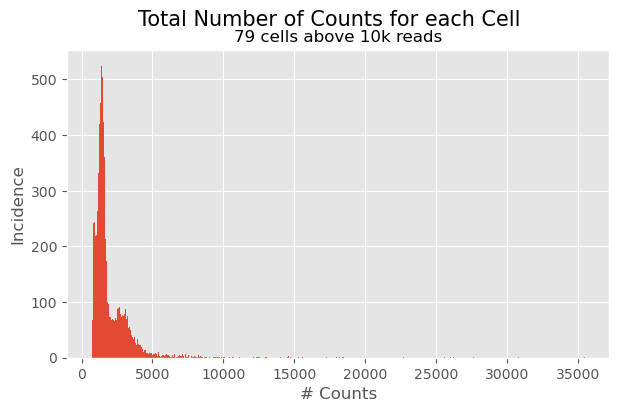

In [13]:
plt.style.use('ggplot')
# plt.style.use('fivethirtyeight')
# plt.style.use('seaborn-v0_8-poster')
plt.hist(adata.obs["X_sum"],bins=1000)
plt.xlabel("# Counts")
plt.ylabel("Incidence")
plt.suptitle("Total Number of Counts for each Cell",
             fontsize=15)
plt.title(f"{cells_above_10k} cells above 10k reads",
          fontsize=12)

fig = plt.gcf()
fig.set_size_inches(7,4)

In [19]:
X = adata.X
X.shape

(14640, 22429)

In [23]:
sc.pp.normalize_total(adata, target_sum=1000)

In [ ]:
sc.pp.log1p(adata)

In [24]:
sc.pp.highly_variable_genes(adata,n_top_genes=30,flavor="seurat_v3")

/home/madan/miniconda3/envs/session3_theory/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:72: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [34]:
sc.pp.neighbors(adata, n_neighbors=10)

In [35]:
sc.tl.umap(adata)

In [39]:
sc.tl.leiden(adata, resolution=0.1)

/tmp/ipykernel_20764/2126912228.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.1)


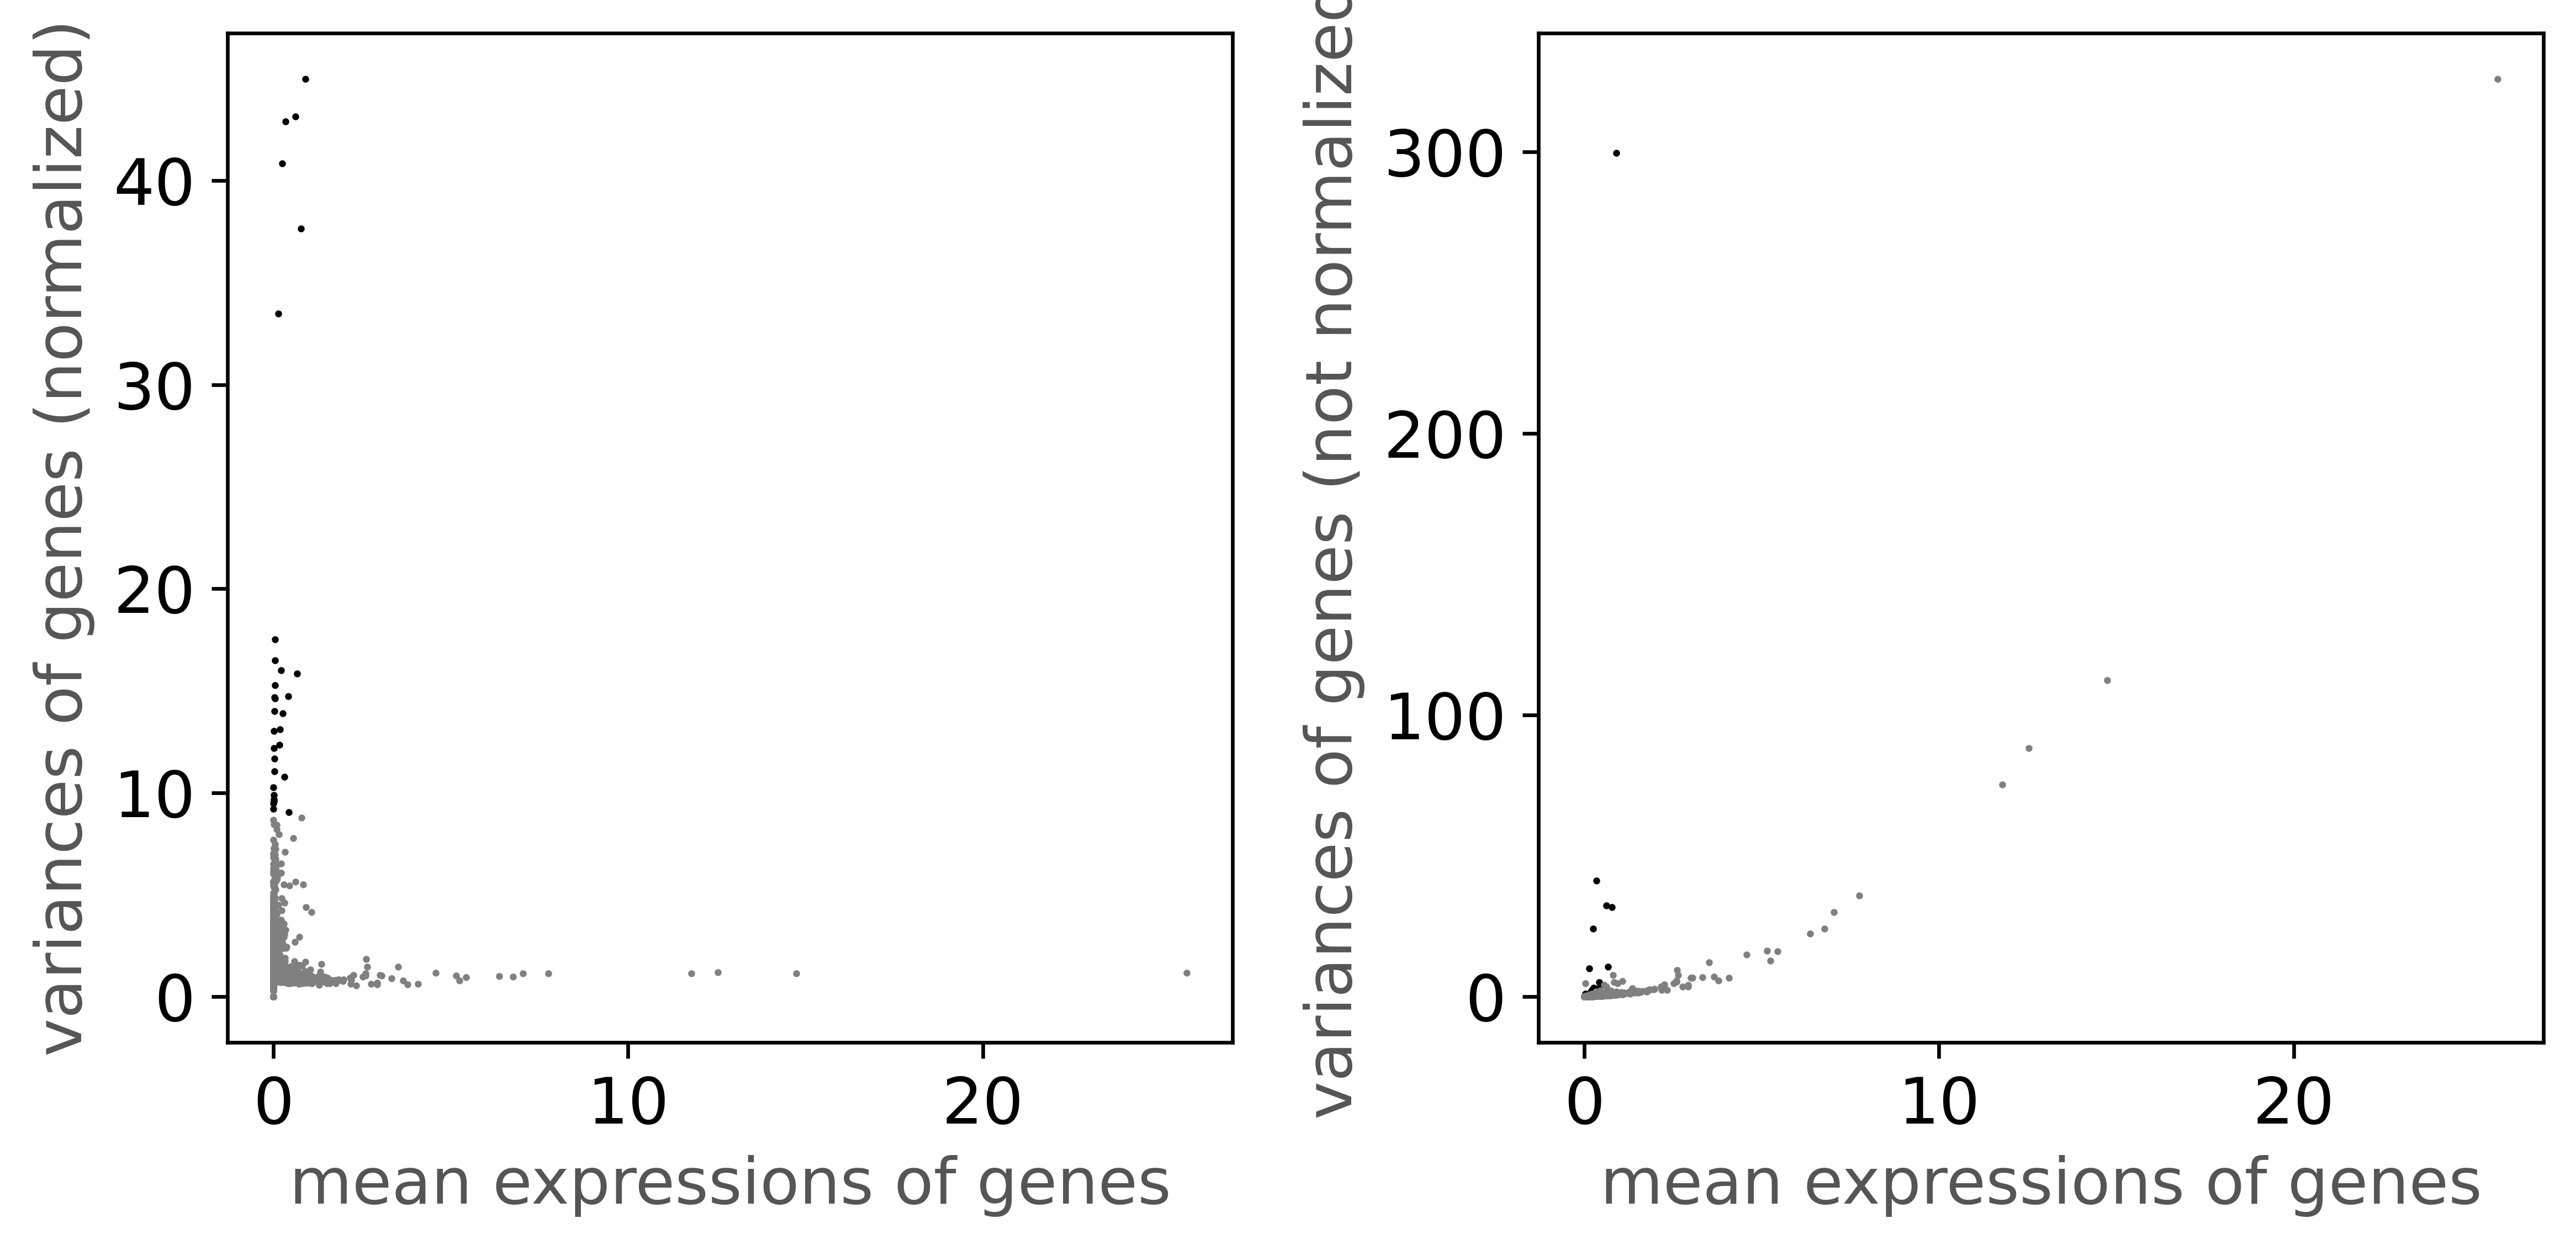

In [28]:
sc.set_figure_params(dpi=300)
sc.pl.highly_variable_genes(adata, show=False)
plt.grid(False)
plt.sca(plt.gcf().axes[0])
plt.gca().get_legend().remove()
plt.grid(False)
plt.gcf().tight_layout()

/home/madan/miniconda3/envs/session3_theory/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


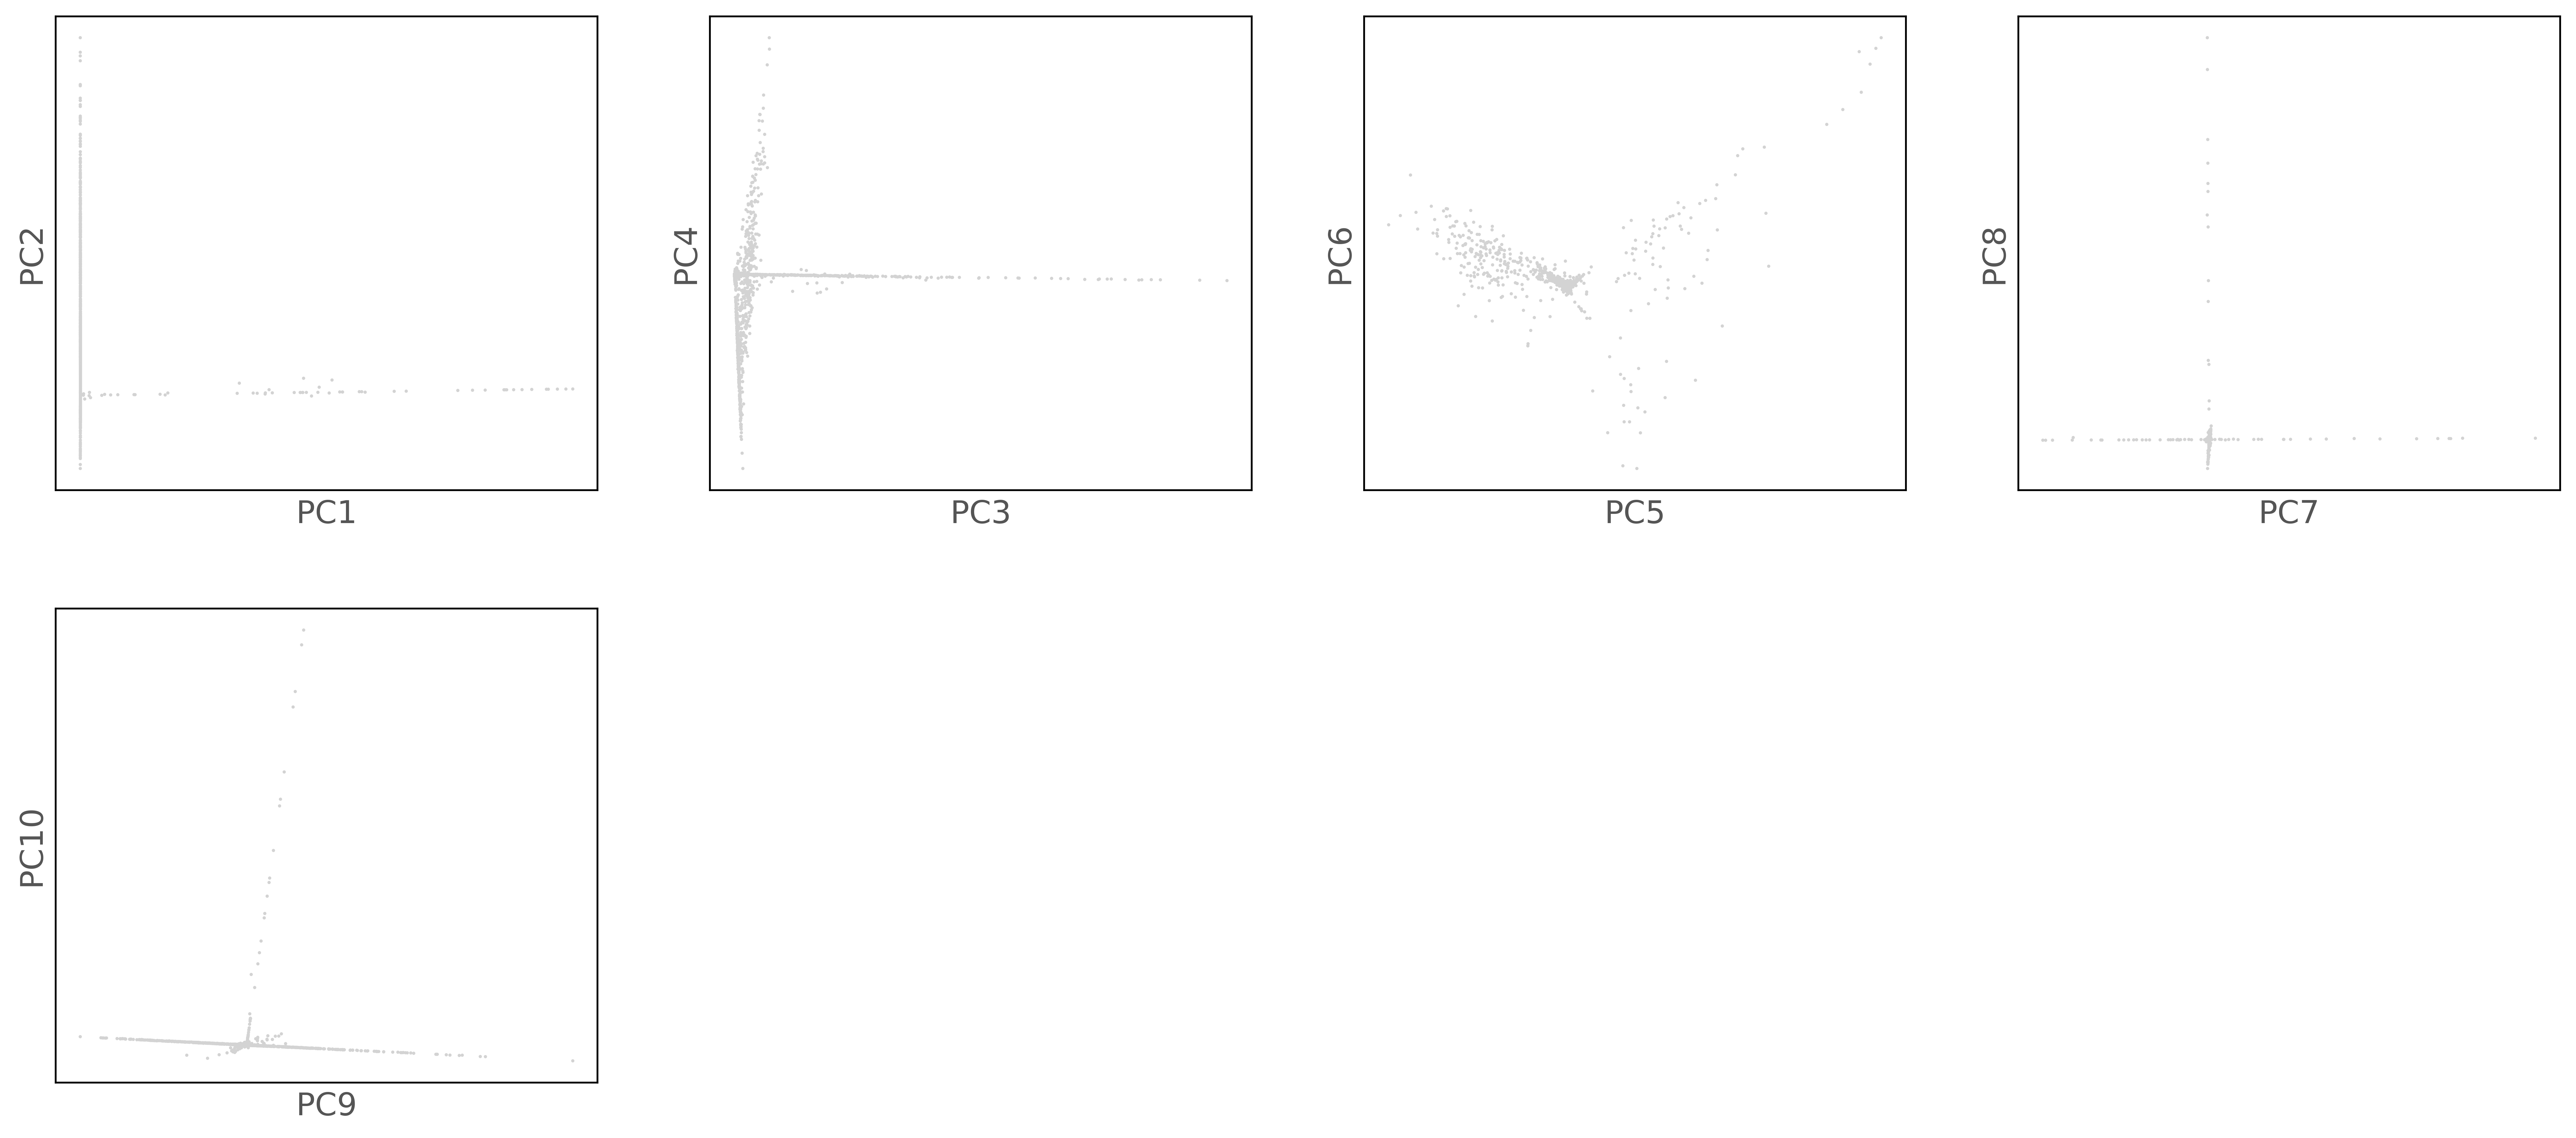

In [31]:
sc.pp.pca(adata, n_comps=10, svd_solver="arpack", use_highly_variable=True)
sc.pl.pca(
    adata, components=["1,2", "3,4", "5,6", "7,8", "9,10"]
)

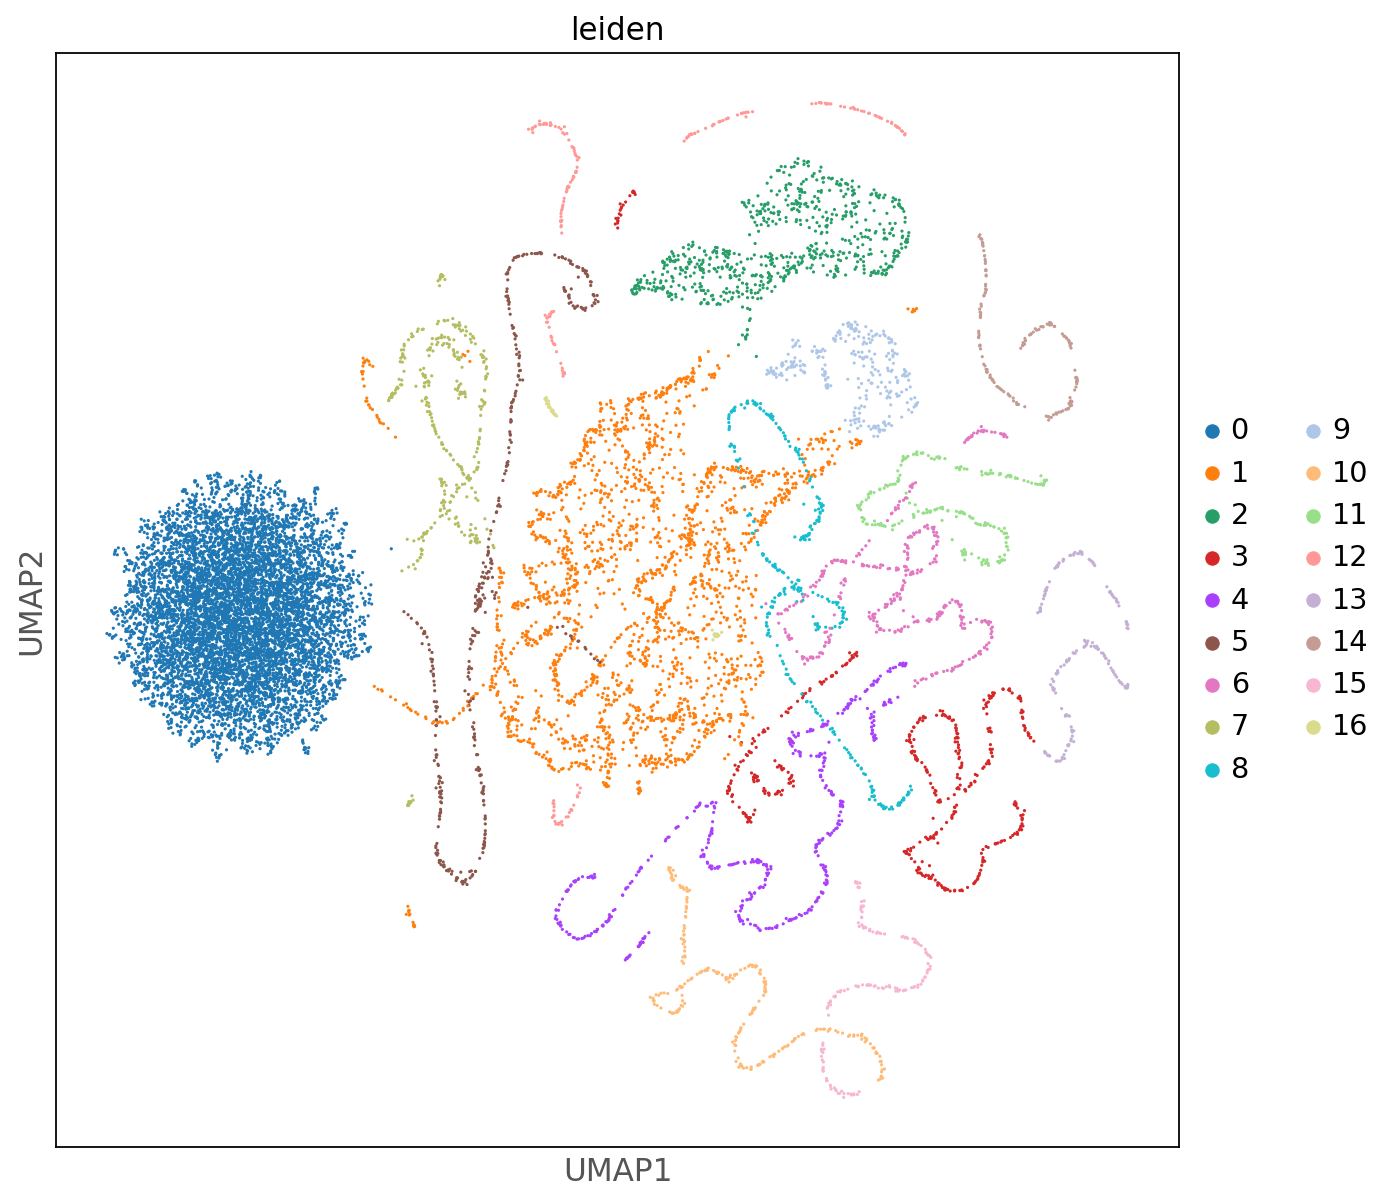

In [44]:
sc.set_figure_params(figsize=(9, 9))
# sc.pl.umap(adata, color="frame", cmap="viridis")
sc.pl.umap(adata, color="leiden",cmap="viridis")
sc.set_figure_params(figsize=None)

In [43]:
sum(adata.obs["leiden"]=="0")

7953